In [1]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
from tqdm import tqdm
from itertools import product
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models

from sklearn.model_selection import train_test_split

# Check for GPU availability
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Reproducibility
Achieving reproducible results is a cornerstone of scientific research. 

In the context of Deep Learning, this means ensuring that a model will produce the same results on the same data, regardless of when or where it is run. This is challenging due to the inherent randomness in model initialization and data shuffling. 
To avoid (or minimize) it, we fix the random seed across all libraries that generate random numbers.

In [2]:
def set_seed(seed=7):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)

    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Numpy RNG
    np.random.seed(seed)

    # OS RNG
    os.environ["PYTHONHASHSEED"] = str(seed)


def worker_init_fn(worker_id):
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)


set_seed(7)

### Hyperparameters

In [24]:
# Hyperparameters
batch_size = 30
dataset_size = 5000  # Reduced dataset size for quicker training

epochs = 50
learning_rate = 0.4

### Dataset

The dataset for this project, obtained from the PizzaGAN project at MIT and accessible on [this website](http://pizzagan.csail.mit.edu/), includes pizza images with labeled toppings. Over 38 million #pizza posts on Instagram were initially filtered to acquire approximately half a million images, with undesired content removed. After this, it was diminished even further until 9,213 pictures with corresponding annotations were left. 

In [5]:
# Import the csv from path.
label_path = "data\pizza_data\imageLabels.txt"
column_path = "data\pizza_data\categories.txt"
image_path = "data\pizza_data\images"

df = pd.read_csv(label_path, sep="  ", header=None)
df.columns = open(column_path, "r").read().split("\n")[:-1]
classes = len(open(column_path, "r").read().split("\n")[:-1]) + 1
open(column_path, "r").close()


# Encode a label of pizzas without labeled toppings.
# df["plain"] = 0
df["image_name"] = df.apply(
    lambda x: os.path.join(image_path, str(x.name + 1).zfill(5) + ".jpg"), axis=1
)
# df.loc[df.iloc[:, 1:-1].max(axis=1) == 0, "plain"] = 1

# Split the data in training and validation.
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=7)
train_df

C:\Users\20202016\AppData\Local\Temp\ipykernel_10312\2008146030.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(label_path, sep="  ", header=None)


,Pepperoni,Bacon,Mushrooms,Onions,Peppers,Black olives,Tomatoes,Spinach,Fresh basil,Arugula,Broccoli,Corn,Pineapple,image_name
2091,0,1,0,1,0,0,1,0,0,0,0,0,0,data\pizza_data\images\02092.jpg
7311,0,0,0,0,0,1,0,0,0,0,0,0,0,data\pizza_data\images\07312.jpg
2855,0,0,1,0,0,0,1,0,1,0,0,0,0,data\pizza_data\images\02856.jpg
8371,0,0,0,0,0,0,0,0,1,0,0,0,0,data\pizza_data\images\08372.jpg
4000,0,0,0,0,0,0,0,0,0,0,0,0,0,data\pizza_data\images\04001.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,0,1,0,0,0,0,0,0,1,0,0,0,0,data\pizza_data\images\01373.jpg
919,0,0,0,1,0,0,0,0,0,0,0,0,0,data\pizza_data\images\00920.jpg
4307,0,0,0,0,0,0,1,0,0,0,0,0,0,data\pizza_data\images\04308.jpg
5699,0,0,0,0,0,0,0,0,0,0,0,0,0,data\pizza_data\images\05700.jpg


In [6]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iat[idx, -1]  # the path is in the first column
        image = Image.open(image_name).convert("RGB")
        labels = torch.tensor(
            self.dataframe.drop("image_name", axis=1).iloc[idx].values.astype("float32")
        )  # Convert to tensor

        # Transform the image
        if self.transform:
            image = self.transform(image)

        return image, labels

In [7]:
# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 5000 - Test set size: 1843


Let's normalize the input data, to improve the learning process, by using Standard Normalization.
we first need to calculate the mean and variance of the pixel values across the entire training dataset. These statistics are then used to normalize both the training and validation/test datasets. 

In [7]:
test_df.loc[4315]

Pepperoni                                      1
Bacon                                          0
Mushrooms                                      0
Onions                                         1
Peppers                                        0
Black olives                                   0
Tomatoes                                       0
Spinach                                        0
Fresh basil                                    0
Arugula                                        0
Broccoli                                       0
Corn                                           0
Pineapple                                      1
image_name      data\pizza_data\images\04316.jpg
Name: 4315, dtype: object

In [7]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0

    for iteration in tqdm(iter(loader)):
        images = iteration[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0)
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images

    return mean, variance


# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

100%|██████████| 246/246 [02:47<00:00,  1.46it/s]

Mean: tensor([0.6236, 0.4790, 0.3629])
Standard Deviation: tensor([0.2324, 0.2434, 0.2430])


In [18]:
mean = torch.Tensor([0.6236, 0.4790, 0.3629])
std = torch.Tensor([0.2324, 0.2434, 0.2430])

Furthermore, we need to add the input normalization.

In [19]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),  # Normalize images
    ]
)

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 5000 - Test set size: 1843


## Input visualization

Let's visualize a set of images from the dataset.

Labels: Pepperoni


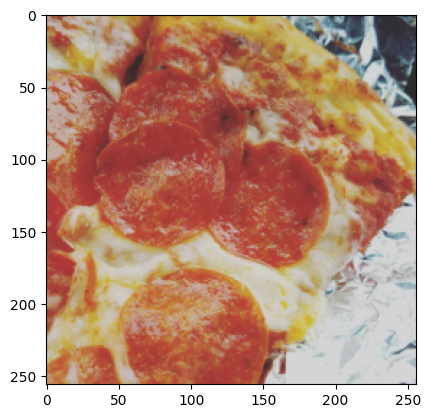

Labels: Pepperoni


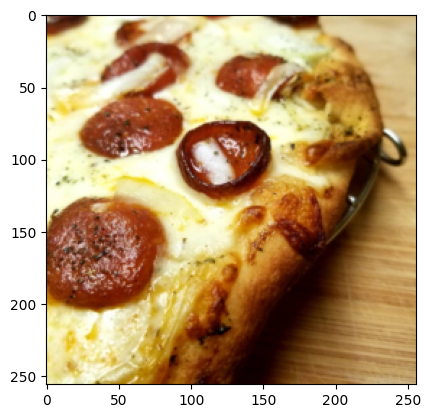

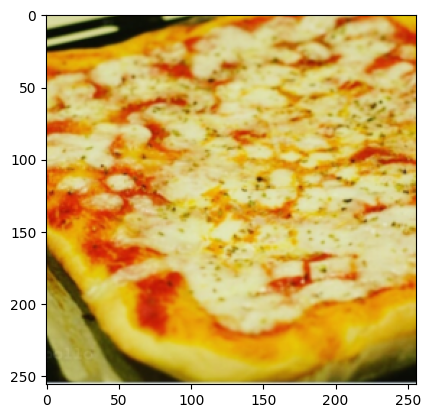

Labels: Mushrooms
Labels: Black olives


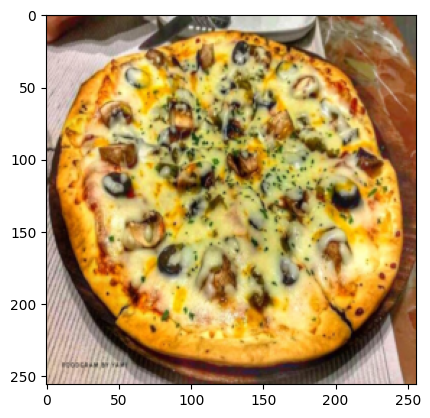

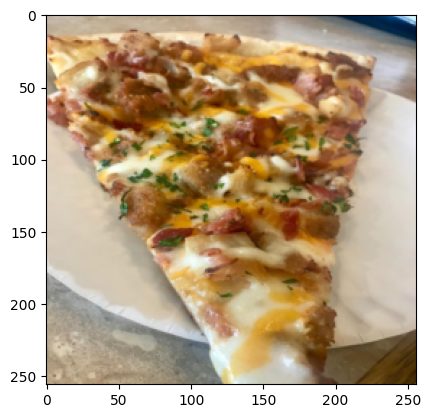

In [20]:
def denormalize(img, mean, std):
    """Denormalizes an image to its original form using mean and std"""
    mean = (
        torch.tensor(mean).reshape(-1, 1, 1)
        if not isinstance(mean, torch.Tensor)
        else mean.reshape(-1, 1, 1)
    )
    std = (
        torch.tensor(std).reshape(-1, 1, 1)
        if not isinstance(std, torch.Tensor)
        else std.reshape(-1, 1, 1)
    )
    denorm_img = img * std + mean  # Apply denormalization
    return denorm_img


def imshow(img, mean, std):
    """Shows an image by first denormalizing it"""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 255)  # Ensure the image is within [0, 255]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return npimg


def display_labels(labels, classes):
    """Display labels given their indices and corresponding class names"""
    for idx, label in enumerate(labels):
        if label == 1:
            print(f"Labels: {classes[idx]}")


# Select random images and plot them with labels
classes = df.columns[:-1]

# Select random images and plot them with labels
num_images = 5
for i in random.sample(range(len(test_dataset)), num_images):
    image, labels = (
        test_dataset[i][0],
        test_dataset[i][1],
    )  # Ensure that you're accessing the tensor image

    # Display the labels
    display_labels(labels, classes)

    # Display the image
    imshow(image, mean, std)

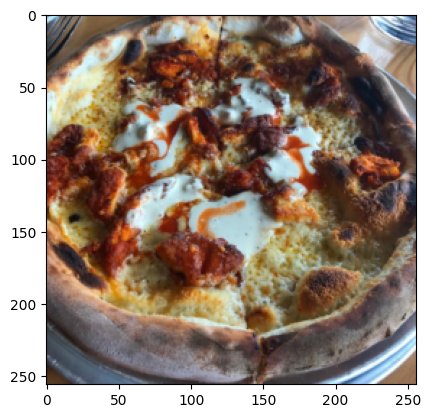

(3, 256, 256)

In [10]:
imshow(test_dataset[0][0], mean, std).shape

## Basic Neural Network Architecture

Let's start our exploration with a basic Linear Model to establish a performance baseline.
 
This model, consisting of a single linear layer, is quick to train but typically underperforms on complex tasks due to its inability to capture non-linear relations in the training data.

In [31]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.375, inplace=True),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=2),
            # nn.BatchNorm2d(64),
            # nn.Dropout(p=0.1, inplace=True),
            # nn.ReLU(inplace=True),
            # nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(128, 32, kernel_size=5, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.05, inplace=True),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            nn.Conv2d(32, 1, kernel_size=7, stride=2, padding=4),
            nn.BatchNorm2d(1),
            nn.Dropout(p=0.025, inplace=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(16, 64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(64, n_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


linear_model = Linear_Model(len(classes)).to(device)
summary(linear_model, (3, 256, 256), device=device)
print("Device is " + device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 13]                  --
|    └─Conv2d: 2-1                       [-1, 64, 258, 258]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 258, 258]        128
|    └─Dropout: 2-3                      [-1, 64, 258, 258]        --
|    └─ReLU: 2-4                         [-1, 64, 258, 258]        --
|    └─AvgPool2d: 2-5                    [-1, 64, 86, 86]          --
|    └─Conv2d: 2-6                       [-1, 128, 88, 88]         73,856
|    └─BatchNorm2d: 2-7                  [-1, 128, 88, 88]         256
|    └─Dropout: 2-8                      [-1, 128, 88, 88]         --
|    └─ReLU: 2-9                         [-1, 128, 88, 88]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 29, 29]         --
|    └─Conv2d: 2-11                      [-1, 32, 16, 16]          102,432
|    └─BatchNorm2d: 2-12                 [-1, 32, 16, 16]          64
|

In [21]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            nn.Dropout(p=0.375, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(p=0.1, inplace=True),
            # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=2),
            # nn.BatchNorm2d(64),
            # nn.Dropout(p=0.1, inplace=True),
            # nn.ReLU(inplace=True),
            # nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(64, 32, kernel_size=5, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            nn.Dropout(p=0.05, inplace=True),
            nn.Conv2d(32, 1, kernel_size=7, stride=2, padding=4),
            nn.BatchNorm2d(1),
            nn.Dropout(p=0.025, inplace=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(16, 64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(64, n_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


linear_model = Linear_Model(len(classes)).to(device)
summary(linear_model, (3, 256, 256), device=device)
print("Device is " + device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 13]                  --
|    └─Conv2d: 2-1                       [-1, 32, 258, 258]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 258, 258]        64
|    └─ReLU: 2-3                         [-1, 32, 258, 258]        --
|    └─AvgPool2d: 2-4                    [-1, 32, 86, 86]          --
|    └─Dropout: 2-5                      [-1, 32, 86, 86]          --
|    └─Conv2d: 2-6                       [-1, 64, 88, 88]          18,496
|    └─BatchNorm2d: 2-7                  [-1, 64, 88, 88]          128
|    └─ReLU: 2-8                         [-1, 64, 88, 88]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 29, 29]          --
|    └─Dropout: 2-10                     [-1, 64, 29, 29]          --
|    └─Conv2d: 2-11                      [-1, 32, 16, 16]          51,232
|    └─BatchNorm2d: 2-12                 [-1, 32, 16, 16]          64
|    

Show more model information regarding parameters.

In [12]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in linear_model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: linear_stack.0.weight, Parameters: 1728
Layer: linear_stack.0.bias, Parameters: 64
Layer: linear_stack.1.weight, Parameters: 64
Layer: linear_stack.1.bias, Parameters: 64
Layer: linear_stack.5.weight, Parameters: 73728
Layer: linear_stack.5.bias, Parameters: 128
Layer: linear_stack.6.weight, Parameters: 128
Layer: linear_stack.6.bias, Parameters: 128
Layer: linear_stack.10.weight, Parameters: 102400
Layer: linear_stack.10.bias, Parameters: 32
Layer: linear_stack.11.weight, Parameters: 32
Layer: linear_stack.11.bias, Parameters: 32
Layer: linear_stack.15.weight, Parameters: 1568
Layer: linear_stack.15.bias, Parameters: 1
Layer: linear_stack.16.weight, Parameters: 1
Layer: linear_stack.16.bias, Parameters: 1
Layer: linear_stack.20.weight, Parameters: 1600
Layer: linear_stack.20.bias, Parameters: 64
Layer: linear_stack.22.weight, Parameters: 832
Layer: linear_stack.22.bias, Parameters: 13

Total number of parameters: 182608


## Loss function and optimizer

When choosing a loss function and an optimizer for a neural network, it's important to consider the specific task at hand. 

For classification tasks, Cross Entropy Loss and optimizers like SGD or Adam are common choices. 

In [16]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

In [27]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.00001)

## Model Training

The training loop is where the model learns from the data. In each epoch, the model makes predictions, calculates the error (loss), and uses backpropagation to adjust the weights. 

### Training Process Overview

During training, for each batch of data, the following steps occur:
1. **Forward Pass:** The model computes predictions based on the input data.
2. **Compute Loss:** The difference between the predictions and the actual labels is calculated using the loss function.
3. **Backward Pass:** The model backpropagates the loss to compute the gradients of the loss with respect to each parameter.
4. **Update Parameters:** The optimizer uses the gradients calculated during the backward pass to update the model's parameters.

In [14]:
# # Training and Validation Loop
# for epoch in tqdm(range(epochs)):
#     print("starting epoch...")
#     # Training Phase
#     model.train()  # Set the model to training mode

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(
#             device
#         )  # Move data to the appropriate device

#         optimizer.zero_grad()  # Zero the gradients to prevent accumulation
#         outputs = model(images)  # Forward pass
#         loss = criterion(outputs, labels)  # Calculate the loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Optimize the model

In [28]:
# Lists to store metrics
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

# Training and Validation Loop
start_time = time.time()
for epoch in range(epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(
            device
        )  # Move data to the appropriate device

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        outputs = model.forward(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

        train_loss += loss.item() * images.size(0)  # Accumulate the loss
        predicted = np.round(outputs.detach().cpu().numpy())  # Get predictions

        total_train += labels.size(0)
        correct_train += sum(
            np.all(np.equal(predicted, labels.detach().cpu().numpy()), axis=1)
        )  # Calculate correct predictions

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print("Finished Training")

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(
                device
            )  # Move data to the appropriate device
            outputs = model.forward(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss

            validation_loss += loss.item() * images.size(0)  # Accumulate the loss
            predicted = np.round(outputs.detach().cpu().numpy())  # Get predictions
            total_val += labels.size(0)
            correct_val += sum(
                np.all(np.equal(predicted, labels.detach().cpu().numpy()), axis=1)
            )  # Calculate correct predictions

    validation_loss /= len(test_loader.dataset)
    validation_accuracy = 100 * correct_val / total_val
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Print metrics
    print(
        f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%"
    )

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)
print(f"\nExecution time: {minutes:02}:{seconds:02}")

100%|██████████| 246/246 [03:47<00:00,  1.08it/s]


Finished Training


100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


Epoch [1/50], Training Loss: 2.6973, Training Accuracy: 0.03%, Validation Loss: 2.6343, Validation Accuracy: 0.00%


100%|██████████| 246/246 [04:17<00:00,  1.05s/it]


Finished Training


100%|██████████| 62/62 [00:56<00:00,  1.11it/s]


Epoch [2/50], Training Loss: 2.6286, Training Accuracy: 0.03%, Validation Loss: 2.5942, Validation Accuracy: 0.00%


100%|██████████| 246/246 [04:11<00:00,  1.02s/it]


Finished Training


100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


Epoch [3/50], Training Loss: 2.6869, Training Accuracy: 1.57%, Validation Loss: 2.6458, Validation Accuracy: 2.77%


100%|██████████| 246/246 [03:42<00:00,  1.11it/s]


Finished Training


100%|██████████| 62/62 [00:43<00:00,  1.42it/s]


Epoch [4/50], Training Loss: 2.6594, Training Accuracy: 1.53%, Validation Loss: 2.6458, Validation Accuracy: 2.77%


100%|██████████| 246/246 [03:27<00:00,  1.18it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.29it/s]


Epoch [5/50], Training Loss: 2.7198, Training Accuracy: 0.23%, Validation Loss: 2.7377, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:37<00:00,  1.13it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.25it/s]


Epoch [6/50], Training Loss: 2.7952, Training Accuracy: 0.00%, Validation Loss: 2.6767, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:40<00:00,  1.11it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch [7/50], Training Loss: 2.6897, Training Accuracy: 0.00%, Validation Loss: 2.5176, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:43<00:00,  1.10it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch [8/50], Training Loss: 2.5420, Training Accuracy: 0.03%, Validation Loss: 2.5090, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:39<00:00,  1.12it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch [9/50], Training Loss: 2.5826, Training Accuracy: 0.00%, Validation Loss: 2.6262, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:38<00:00,  1.13it/s]


Finished Training


100%|██████████| 62/62 [00:50<00:00,  1.24it/s]


Epoch [10/50], Training Loss: 2.6319, Training Accuracy: 0.00%, Validation Loss: 2.5584, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:37<00:00,  1.13it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch [11/50], Training Loss: 2.5873, Training Accuracy: 0.01%, Validation Loss: 2.5584, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:39<00:00,  1.12it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch [12/50], Training Loss: 2.7242, Training Accuracy: 0.11%, Validation Loss: 2.7411, Validation Accuracy: 0.05%


100%|██████████| 246/246 [03:38<00:00,  1.12it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.27it/s]


Epoch [13/50], Training Loss: 2.6637, Training Accuracy: 3.35%, Validation Loss: 2.6057, Validation Accuracy: 1.09%


100%|██████████| 246/246 [03:37<00:00,  1.13it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch [14/50], Training Loss: 2.6402, Training Accuracy: 0.77%, Validation Loss: 2.5942, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:38<00:00,  1.12it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.24it/s]


Epoch [15/50], Training Loss: 2.6613, Training Accuracy: 0.00%, Validation Loss: 2.6618, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:37<00:00,  1.13it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.25it/s]


Epoch [16/50], Training Loss: 2.7046, Training Accuracy: 0.00%, Validation Loss: 2.8616, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:39<00:00,  1.12it/s]


Finished Training


100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch [17/50], Training Loss: 2.8675, Training Accuracy: 0.00%, Validation Loss: 2.8616, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:38<00:00,  1.13it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.31it/s]


Epoch [18/50], Training Loss: 2.7557, Training Accuracy: 0.00%, Validation Loss: 2.5766, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:36<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.29it/s]


Epoch [19/50], Training Loss: 2.5764, Training Accuracy: 0.00%, Validation Loss: 2.5090, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:35<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.28it/s]


Epoch [20/50], Training Loss: 2.7422, Training Accuracy: 0.00%, Validation Loss: 2.6455, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:35<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:50<00:00,  1.22it/s]


Epoch [21/50], Training Loss: 2.6992, Training Accuracy: 0.00%, Validation Loss: 2.7187, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:35<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.27it/s]


Epoch [22/50], Training Loss: 2.6272, Training Accuracy: 0.01%, Validation Loss: 2.5131, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:34<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.27it/s]


Epoch [23/50], Training Loss: 2.6601, Training Accuracy: 0.01%, Validation Loss: 2.6501, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:33<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.31it/s]


Epoch [24/50], Training Loss: 2.6531, Training Accuracy: 0.00%, Validation Loss: 2.5942, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:34<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


Epoch [25/50], Training Loss: 2.6494, Training Accuracy: 0.00%, Validation Loss: 2.6975, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.30it/s]


Epoch [26/50], Training Loss: 2.7604, Training Accuracy: 0.00%, Validation Loss: 2.6989, Validation Accuracy: 0.05%


100%|██████████| 246/246 [03:34<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.30it/s]


Epoch [27/50], Training Loss: 2.6762, Training Accuracy: 0.07%, Validation Loss: 2.5670, Validation Accuracy: 0.11%


100%|██████████| 246/246 [03:34<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.29it/s]


Epoch [28/50], Training Loss: 2.5874, Training Accuracy: 0.08%, Validation Loss: 2.5742, Validation Accuracy: 0.11%


100%|██████████| 246/246 [03:36<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.29it/s]


Epoch [29/50], Training Loss: 2.6255, Training Accuracy: 0.03%, Validation Loss: 2.5532, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:35<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


Epoch [30/50], Training Loss: 2.9386, Training Accuracy: 0.00%, Validation Loss: 2.7956, Validation Accuracy: 0.05%


100%|██████████| 246/246 [03:35<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


Epoch [31/50], Training Loss: 2.8092, Training Accuracy: 0.15%, Validation Loss: 2.7956, Validation Accuracy: 0.05%


100%|██████████| 246/246 [03:33<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:46<00:00,  1.32it/s]


Epoch [32/50], Training Loss: 2.8104, Training Accuracy: 0.15%, Validation Loss: 2.7956, Validation Accuracy: 0.05%


100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.29it/s]


Epoch [33/50], Training Loss: 2.7565, Training Accuracy: 0.46%, Validation Loss: 2.7348, Validation Accuracy: 0.22%


100%|██████████| 246/246 [03:33<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.30it/s]


Epoch [34/50], Training Loss: 2.7764, Training Accuracy: 1.76%, Validation Loss: 2.7536, Validation Accuracy: 2.39%


100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


Epoch [35/50], Training Loss: 2.6103, Training Accuracy: 4.76%, Validation Loss: 2.5481, Validation Accuracy: 1.36%


100%|██████████| 246/246 [03:32<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.31it/s]


Epoch [36/50], Training Loss: 2.5805, Training Accuracy: 0.85%, Validation Loss: 2.5481, Validation Accuracy: 1.36%


100%|██████████| 246/246 [03:34<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


Epoch [37/50], Training Loss: 2.5728, Training Accuracy: 0.11%, Validation Loss: 2.5508, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:34<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.28it/s]


Epoch [38/50], Training Loss: 2.6411, Training Accuracy: 0.22%, Validation Loss: 2.5491, Validation Accuracy: 0.11%


100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


Epoch [39/50], Training Loss: 2.5856, Training Accuracy: 0.11%, Validation Loss: 2.5491, Validation Accuracy: 0.11%


100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.31it/s]


Epoch [40/50], Training Loss: 2.6165, Training Accuracy: 0.09%, Validation Loss: 2.5090, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:31<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:46<00:00,  1.33it/s]


Epoch [41/50], Training Loss: 2.7101, Training Accuracy: 0.75%, Validation Loss: 2.7536, Validation Accuracy: 2.39%


100%|██████████| 246/246 [03:30<00:00,  1.17it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.31it/s]


Epoch [42/50], Training Loss: 2.8052, Training Accuracy: 0.90%, Validation Loss: 2.8270, Validation Accuracy: 0.33%


100%|██████████| 246/246 [03:29<00:00,  1.18it/s]


Finished Training


100%|██████████| 62/62 [00:46<00:00,  1.33it/s]


Epoch [43/50], Training Loss: 2.8377, Training Accuracy: 0.42%, Validation Loss: 2.6588, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:33<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.31it/s]


Epoch [44/50], Training Loss: 2.6460, Training Accuracy: 0.00%, Validation Loss: 2.5457, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.30it/s]


Epoch [45/50], Training Loss: 2.5534, Training Accuracy: 0.00%, Validation Loss: 2.5028, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:47<00:00,  1.31it/s]


Epoch [46/50], Training Loss: 2.6117, Training Accuracy: 0.00%, Validation Loss: 2.5646, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Finished Training


100%|██████████| 62/62 [00:46<00:00,  1.32it/s]


Epoch [47/50], Training Loss: 2.6514, Training Accuracy: 0.04%, Validation Loss: 2.6962, Validation Accuracy: 0.16%


100%|██████████| 246/246 [03:31<00:00,  1.17it/s]


Finished Training


100%|██████████| 62/62 [00:46<00:00,  1.32it/s]


Epoch [48/50], Training Loss: 2.6548, Training Accuracy: 0.39%, Validation Loss: 2.5584, Validation Accuracy: 0.00%


100%|██████████| 246/246 [03:35<00:00,  1.14it/s]


Finished Training


100%|██████████| 62/62 [00:48<00:00,  1.27it/s]


Epoch [49/50], Training Loss: 2.5952, Training Accuracy: 0.07%, Validation Loss: 2.5742, Validation Accuracy: 0.11%


100%|██████████| 246/246 [03:34<00:00,  1.15it/s]


Finished Training


100%|██████████| 62/62 [00:46<00:00,  1.32it/s]

Epoch [50/50], Training Loss: 2.6736, Training Accuracy: 0.50%, Validation Loss: 2.6930, Validation Accuracy: 1.09%

Execution time: 221:17


In [80]:
train_df[train_df.columns[:-1]].sum() / len(train_df)

Pepperoni       0.218860
Bacon           0.020488
Mushrooms       0.095115
Onions          0.100407
Peppers         0.088467
Black olives    0.093758
Tomatoes        0.198779
Spinach         0.045862
Fresh basil     0.140841
Arugula         0.023745
Broccoli        0.008548
Corn            0.027137
Pineapple       0.008141
dtype: float64

In [21]:
predicted

array([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)

### Other

In [ ]:
# @title
def train_model(model, train_sampler, optimizer, loss_function):
    # Lets keep track of all the losses:
    losses = []
    # Put the model in train mode:
    model.train()
    # Feed all the batches one by one:
    for batch in tqdm(train_sampler):
        # Get a batch:
        x, y = batch
        # Making sure our samples are stored on the same device as our model:
        x, y = x.to(device), y.to(device)
        # Get predictions:
        predictions = model.forward(x)
        loss = loss_function(predictions, y)
        losses.append(loss)
        # We first need to make sure we reset our optimizer at the start.
        # We want to learn from each batch seperately,
        # not from the entire dataset at once.
        optimizer.zero_grad()
        # We now backpropagate our loss through our model:
        loss.backward()
        # We then make the optimizer take a step in the right direction.
        optimizer.step()
    return losses


def test_model(model, test_sampler, loss_function):
    # Setting the model to evaluation mode:
    model.eval()
    losses = []
    # We need to make sure we do not update our model based on the test data:
    with torch.no_grad():
        for x, y in tqdm(test_sampler):
            # Making sure our samples are stored on the same device as our model:
            x = x.to(device)
            y = y.to(device)
            prediction = model.forward(x)
            loss = loss_function(prediction, y)
            losses.append(loss)
    return losses


class BatchSampler:
    """
    Implements an iterable which given a torch dataset and a batch_size
    will produce batches of data of that given size. The batches are
    returned as tuples in the form (images, labels).
    Can produce balanced batches, where each batch will have an equal
    amount of samples from each class in the dataset. If your dataset is heavily
    imbalanced, this might mean throwing away a lot of samples from
    over-represented classes!
    """

    def __init__(self, batch_size, dataset, balanced=False):
        self.batch_size = batch_size
        self.dataset = dataset
        self.balanced = balanced
        if self.balanced:
            # Counting the ocurrence of the class labels:
            unique, counts = np.unique(self.dataset.targets, return_counts=True)
            indexes = []
            # Sampling an equal amount from each class:
            for i in range(len(unique)):
                indexes.append(
                    np.random.choice(
                        np.where(self.dataset.targets == i)[0],
                        size=counts.min(),
                        replace=False,
                    )
                )
            # Setting the indexes we will sample from later:
            self.indexes = np.concatenate(indexes)
        else:
            # Setting the indexes we will sample from later (all indexes):
            self.indexes = [i for i in range(len(dataset))]

    def __len__(self):
        return (len(self.indexes) // self.batch_size) + 1

    def shuffle(self):
        # We do not need to shuffle if we use the balanced sampling method.
        # Shuffling is already done when making the balanced samples.
        if not self.balanced:
            random.shuffle(self.indexes)

    def __iter__(self):
        remaining = False
        self.shuffle()
        # Go over the datset in steps of 'self.batch_size':
        for i in range(0, len(self.indexes), self.batch_size):
            imgs, labels = [], []
            # If our current batch is larger than the remaining data, we quit:
            if i + self.batch_size > len(self.indexes):
                remaining = True
                break
            # If not, we yield a complete batch:
            else:
                # Getting a list of samples from the dataset, given the indexes we defined:
                X_batch = [
                    self.dataset[self.indexes[k]][0]
                    for k in range(i, i + self.batch_size)
                ]
                Y_batch = [
                    self.dataset[self.indexes[k]][1]
                    for k in range(i, i + self.batch_size)
                ]
                # Stacking all the samples and returning the target labels as a tensor:
                yield torch.stack(X_batch).float(), torch.stack(Y_batch).float()
        # If there is still data left that was not a full batch:
        if remaining:
            # Return the last batch (smaller than batch_size):
            X_batch = [
                self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))
            ]
            Y_batch = [
                self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))
            ]
            yield torch.stack(X_batch).float(), torch.stack(Y_batch).float()

In [ ]:
train_sampler = BatchSampler(
    batch_size=batch_size, dataset=train_dataset, balanced=False
)
test_sampler = BatchSampler(batch_size=batch_size, dataset=test_dataset, balanced=False)

mean_losses_train = []
mean_losses_test = []
accuracies = []
for e in range(epochs):
    # Training:
    losses = train_model(model, train_sampler, optimizer, criterion)
    # Calculating and printing statistics:
    mean_loss = sum(losses) / len(losses)
    mean_losses_train.append(mean_loss)
    print(f"\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n")

    # Testing:
    losses = test_model(model, test_sampler, criterion)
    # Calculating and printing statistics:
    mean_loss = sum(losses) / len(losses)
    mean_losses_test.append(mean_loss)
    print(f"\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n")
    with torch.no_grad():
        correct = 0
        count = 0
        for x, y in test_sampler:
            # Making sure our samples are stored on the same device as our model:
            x = x.to(device)
            y = y.to(device)
            prediction = model.forward(x)
            correct += sum((prediction.round() == y).all(dim=1))
            count += len(y)
        accuracy = (correct / count).detach().cpu().numpy()
        accuracies.append(accuracy)
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(mean_losses_train, label="Train loss")
    ax.plot(mean_losses_test, label="Test loss")
    ax2.plot(accuracies, label="Accuracy", c="r")
    ax.legend(["Train loss", "Test loss", "Accuracy"])
    plt.show()

In [195]:
len(y)

30

In [188]:
model.forward(x).round()

tensor([[0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0

In [189]:
y

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0